## Initial Local Creation of Bayesian Network

## HC + Bdeu

The experimentation and testing of the initial simple Bayesian Network on a smaller dataset for testing

In [1]:
import pgmpy
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import sys
sys.path.insert(0,"..")
from Data.DataPreprocessing import DataPreprocessing as myData
from pgmpy import estimators
from pgmpy.inference import VariableElimination
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score


c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data importing and preprocessing

In [2]:
loaded_data = myData.load_data()
#display(loaded_data)
data = myData.preprocess_data(loaded_data)
train_data, validation_data,  test_data = myData.split_data(data,num_rows = 10000)

feature_states = myData.get_feature_states(data)

c:\Users\zachs\Documents\CSHons\ResearchReport\Research_Code\Honours-Research\HC_differentScores\..\Data\DataPreprocessing.py:14: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/accepted_2007_to_2018Q4.csv", engine='c')
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(esti

### Structure Learning

In [3]:
scoring_method = estimators.BDeuScore(data=train_data, equivalent_sample_size=10)  # TODO change sample size hyperparameter
est = estimators.HillClimbSearch(data=train_data, use_cache = True)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e3))

model = pgmpy.models.BayesianNetwork(estimated_model.edges())
model.add_nodes_from(estimated_model.nodes())
print(model.nodes())
print(model.edges())

 19%|█▉        | 189/1000 [01:36<06:52,  1.97it/s]

['loan_amnt', 'total_pymnt', 'total_rec_int', 'last_pymnt_amnt', 'max_bal_bc', 'recoveries', 'annual_inc', 'title', 'term', 'grade', 'initial_list_status', 'verification_status', 'issue_d', 'int_rate', 'installment', 'total_rec_late_fee', 'loan_status', 'home_ownership', 'mort_acc', 'dti', 'application_type', 'disbursement_method', 'last_credit_pull_d', 'last_fico_range_high', 'debt_settlement_flag', 'purpose', 'delinq_2yrs', 'num_tl_90g_dpd_24m', 'earliest_cr_line', 'mo_sin_old_rev_tl_op', 'emp_length', 'mo_sin_old_il_acct', 'fico_range_high', 'pub_rec_bankruptcies', 'pub_rec', 'inq_last_6mths', 'collections_12_mths_ex_med', 'open_acc', 'tot_cur_bal', 'avg_cur_bal', 'revol_bal', 'total_bal_il', 'total_bal_ex_mort', 'revol_util', 'bc_util', 'all_util', 'num_actv_rev_tl', 'open_acc_6m', 'total_acc', 'num_accts_ever_120_pd', 'chargeoff_within_12_mths', 'tax_liens', 'tot_coll_amt', 'acc_now_delinq', 'num_tl_30dpd', 'delinq_amnt', 'num_tl_op_past_12m', 'mo_sin_rcnt_tl', 'open_act_il', 'ope

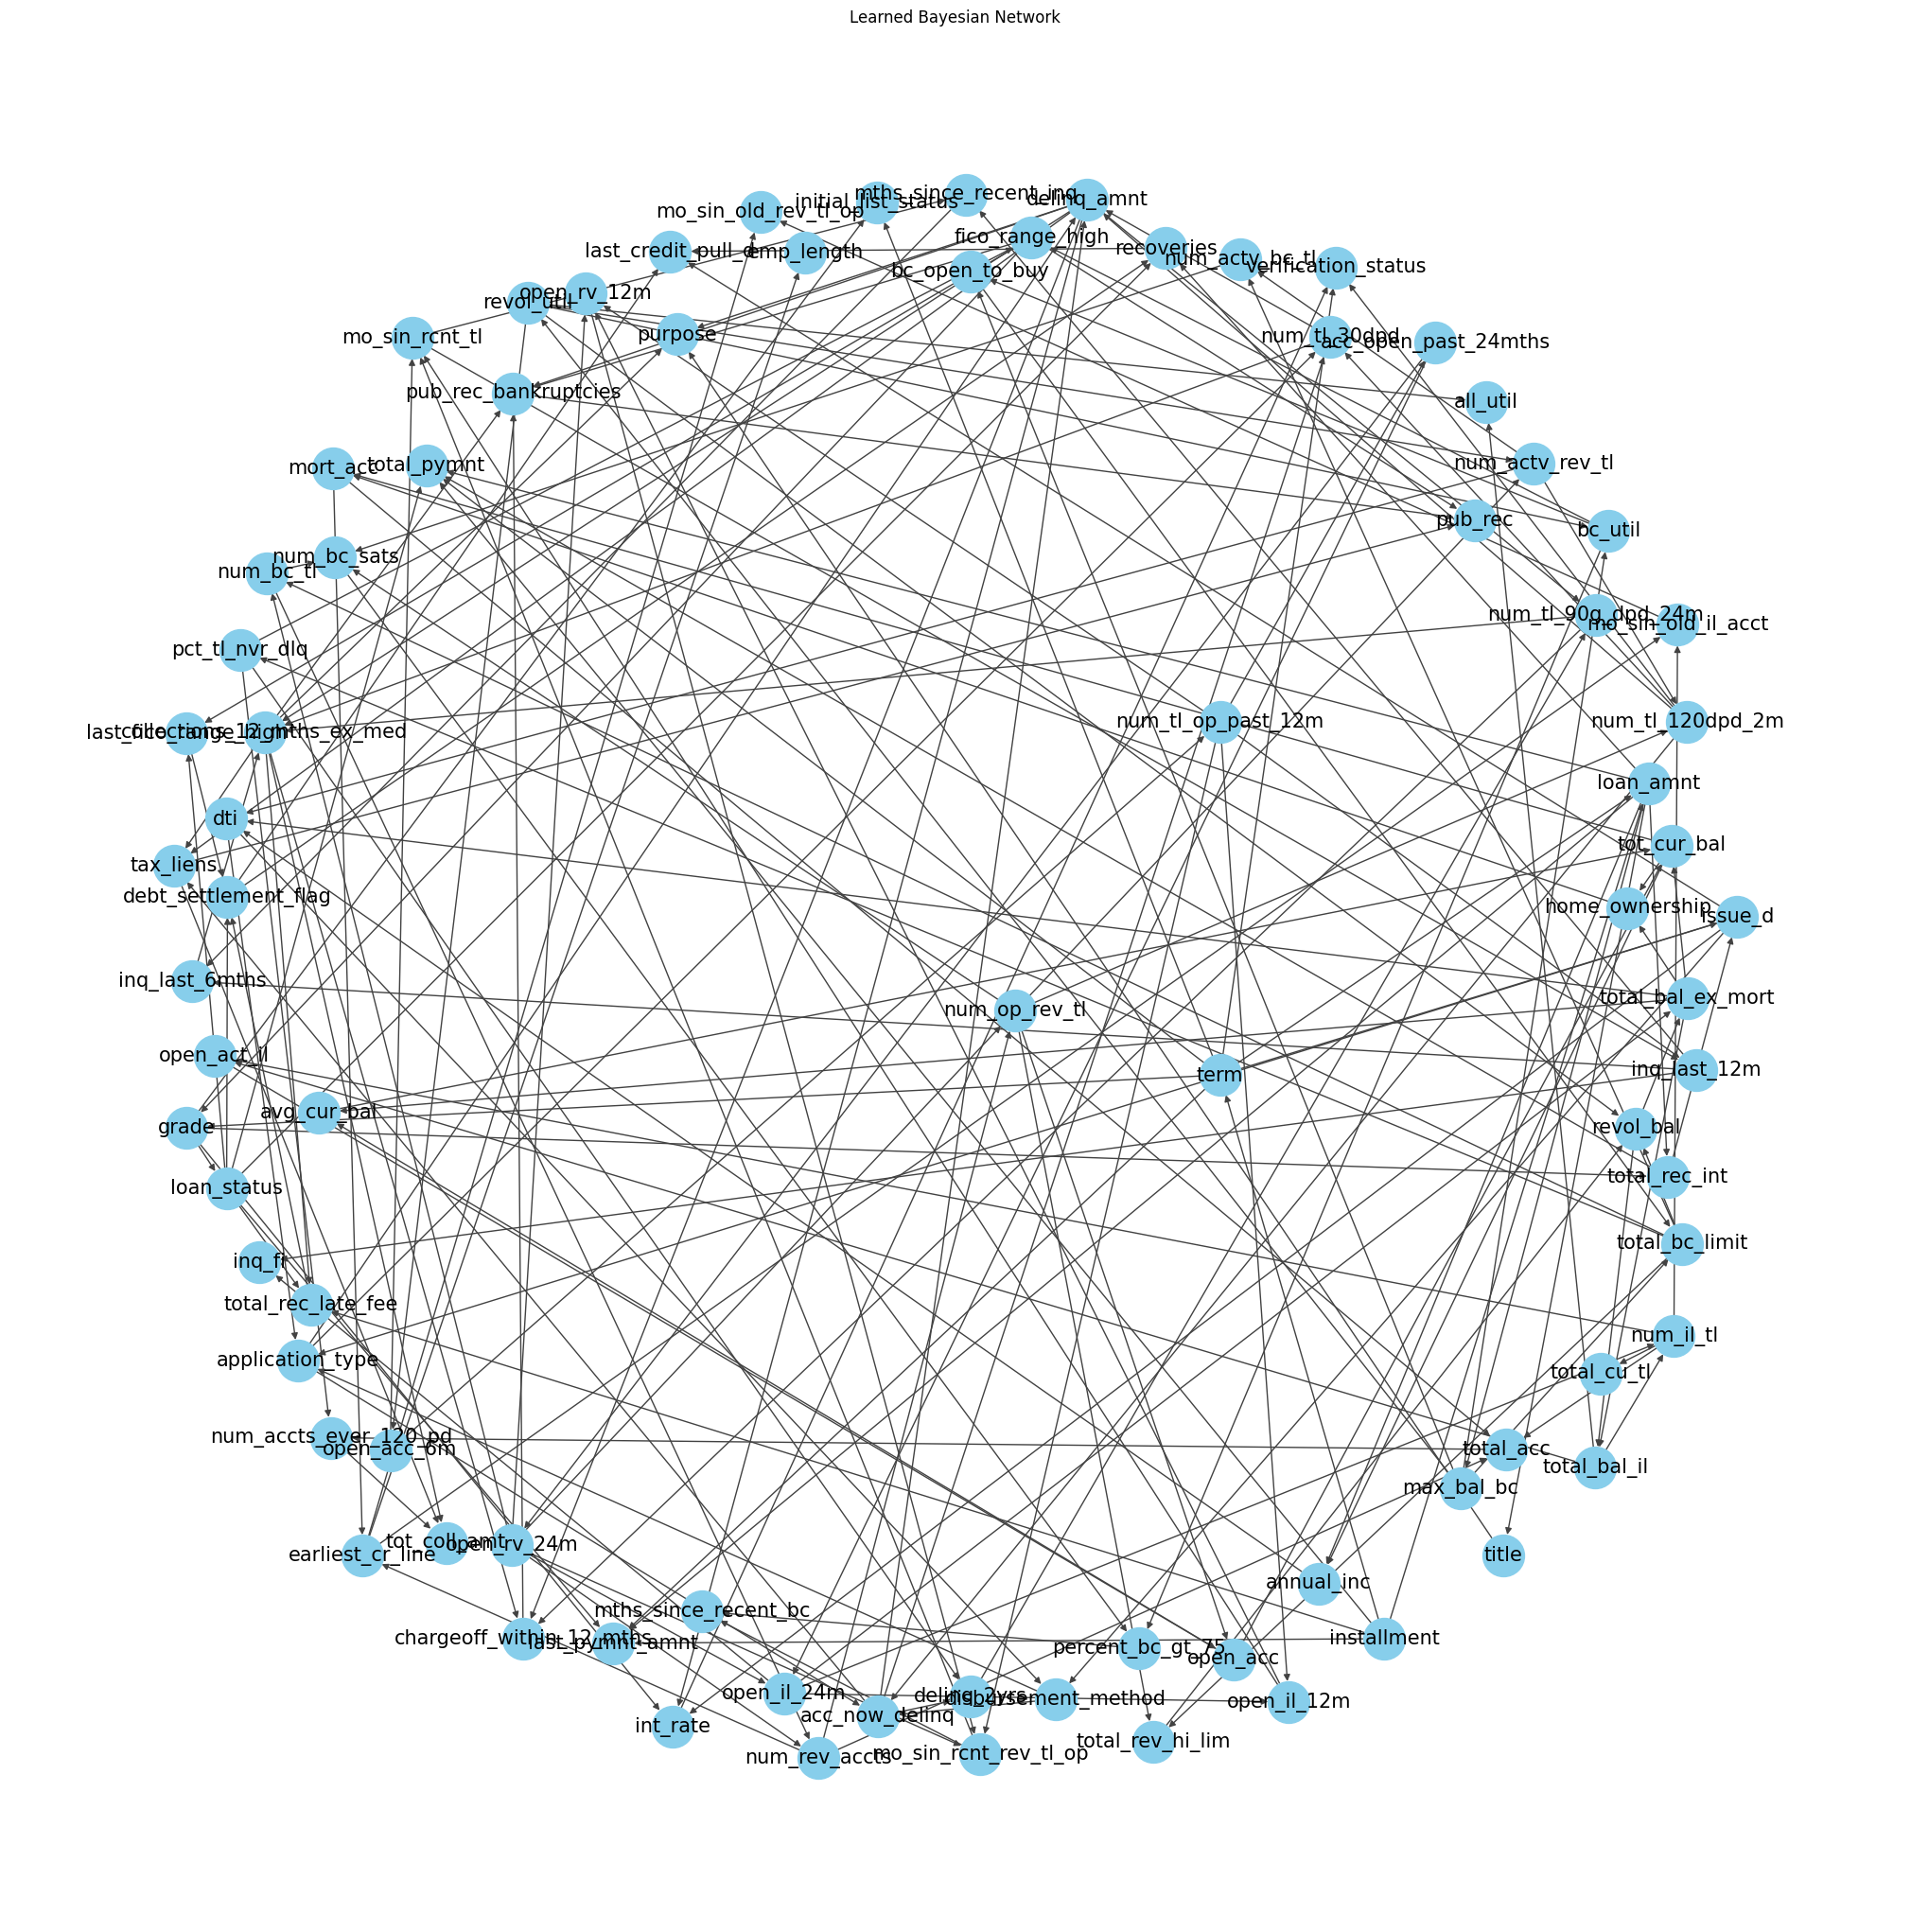

In [4]:
active_trail_nodes = model.active_trail_nodes('loan_status')['loan_status']
active_trail_nodes_list = list(active_trail_nodes)
original_nodes = list(model.nodes())
for node in original_nodes:
    if node not in active_trail_nodes_list:
        model.remove_node(node)
        

nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(20, 20))
nx.draw(nx_graph, pos, with_labels=True, node_size=1000, node_color = 'skyblue', edge_color='#424242',font_size=15,font_color='black')
plt.title('Learned Bayesian Network')
plt.show()

###  Parameter Estimation

In [5]:
parameter_estimator = estimators.BayesianEstimator(model,train_data, state_names = feature_states)
parameters = parameter_estimator.get_parameters(n_jobs=6)

for i in range(len(parameters)):
    model.add_cpds(parameters[i])
    #print(parameters[i])

### Inference

In [6]:
def performInference(target_label_list, val_test_data):
    removed_attributes = set()
    y_pred = []
    y_true = []    
    validation_evidence_list = myData.get_evidence_list(val_test_data, target_label_list=target_label_list)
    inference = VariableElimination(model)
    for i in range(len(validation_evidence_list)):
        for attribute in list(validation_evidence_list[i].keys()):
            if attribute not in model.nodes():
                removed_attributes.add(attribute)
                del validation_evidence_list[i][attribute]
    print(removed_attributes)            
    for i in range(len(validation_evidence_list)):
        target_variables_result = inference.map_query(target_label_list, evidence = validation_evidence_list[i], show_progress= False) 
        #print(target_variables_result)
        #print(val_test_data[target_label_list].iloc[i].to_dict())
        y_pred.append(target_variables_result)
        y_true.append(val_test_data[target_label_list].iloc[i].to_dict())
    
    return y_pred, y_true

loan_structure_target_list = ["int_rate","term","installment","disbursement_method"]    
y_pred, y_true = performInference(loan_structure_target_list, validation_data)    


set()


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

## Testing

In [7]:
def testModel(y_true, y_pred):
    data_testing_corr_score = model.simulate(int(1e4))
    correlation_score_value = correlation_score(model, data_testing_corr_score, test="log_likelihood", significance_level=0.05)
    log_likelihood_score_value = log_likelihood_score(model, data_testing_corr_score)
    structure_score_value = structure_score(model, data_testing_corr_score, scoring_method="bic")
    print("correlation score: " + str(correlation_score_value))
    print("Log likelihood score: " + str(log_likelihood_score_value))
    print("Structure score: "+ str(structure_score_value))

    accuracy_score_value = accuracy_score(y_true, y_pred)
    f1score_value = f1_score(y_true, y_pred, average = None)
    precisionScore = precision_score(y_true, y_pred,average = None)
    recallScore = recall_score(y_true, y_pred,average = None)
    #roc_auc_score_value =  roc_auc_score(y_true, y_pred,average = None)
    balanced_accuracy_score_value = balanced_accuracy_score(y_true, y_pred, adjusted=True)

    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    precision_score_macro = precision_score(y_true, y_pred, average='macro')
    recall_score_macro = recall_score(y_true, y_pred, average='macro')

    f1_score_weighted = f1_score(y_true, y_pred, average = 'weighted')
    precision_score_weighted = precision_score(y_true, y_pred, average = 'weighted')
    recall_score_weighted = recall_score(y_true, y_pred, average = 'weighted')

    print("accuracy score: "+str(accuracy_score_value))
    print("f1_score: "+str(f1score_value))
    print("precision score: "+str(precisionScore))
    print("recall score: "+str(recallScore))
    #print("roc auc score: "+str(roc_auc_score_value))
    print("balanced_accuracy_score: " + str(balanced_accuracy_score_value))
    print("\n\n")
    print("Macro scores:\n")
    print("recall_score_macro: "+str(recall_score_macro))
    print("f1_score_macro: "+str(f1_score_macro))
    print("precision_score_macro: "+str(precision_score_macro))
    print("\n")
    print("Weighted Scores:\n")
    print("recall_score_weighted: "+str(recall_score_weighted))
    print("f1_score_weighted: "+str(f1_score_weighted))
    print("precision_score_weighted: "+str(precision_score_weighted))
    
    
testModel(loan_status_y_true, loan_status_y_pred)

Generating for node: last_credit_pull_d: 100%|██████████| 82/82 [00:00<00:00, 100.41it/s]
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


correlation score: 0.0
Log likelihood score: -478340.991611363
Structure score: -587236.8326453059
accuracy score: 0.663
f1_score: [0.22170901 0.78493937]
precision score: [0.2364532  0.77164366]
recall score: [0.20869565 0.7987013 ]
balanced_accuracy_score: 0.007396950875211639



Macro scores:

recall_score_macro: 0.5036984754376058
f1_score_macro: 0.5033241907647776
precision_score_macro: 0.5040484328547323


Weighted Scores:

recall_score_weighted: 0.663
f1_score_weighted: 0.655396390036418
precision_score_weighted: 0.6485498575322485


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

def exact_match_ratio(y_true, y_pred):
    """
    Calculate the Exact Match Ratio (Subset Accuracy).
    """
    return np.mean([set(yt.items()) == set(yp.items()) for yt, yp in zip(y_true, y_pred)])

def custom_hamming_loss(y_true, y_pred):
    """
    Calculate the Hamming Loss.
    """
    total_labels = sum(len(yt) for yt in y_true)
    incorrect = sum(sum(yt[key] != yp.get(key, None) for key in yt.keys()) for yt, yp in zip(y_true, y_pred))
    return incorrect / total_labels

def precision_recall_f1(y_true, y_pred):
    """
    Calculate Precision, Recall, and F1 score for each label.
    Returns a dictionary containing these metrics per label.
    """
    # Collect all unique labels from both true and predicted data
    all_labels = set().union(*(yt.keys() for yt in y_true))
    precision = {}
    recall = {}
    f1 = {}

    for label in all_labels:
        # Extract the true and predicted values for this label across all samples
        true_vals = [(yt.get(label, None)) for yt in y_true]
        pred_vals = [(yp.get(label, None)) for yp in y_pred]
        
        # Calculate precision, recall, f1 for each label
        precision[label] = precision_score(true_vals, pred_vals, average='macro', zero_division=1)
        recall[label] = recall_score(true_vals, pred_vals, average='macro', zero_division=1)
        f1[label] = 2 * (precision[label] * recall[label]) / (precision[label] + recall[label]) if (precision[label] + recall[label]) != 0 else 0

    return precision, recall, f1

def aggregated_f1(y_true, y_pred):
    """
    Calculate the average F1 score across all labels.
    """
    precision, recall, f1 = precision_recall_f1(y_true, y_pred)
    return np.mean(list(f1.values()))

def evaluate_multilabel_classification(y_true, y_pred):
    """
    This function calculates and prints all relevant metrics for multilabel-multioutput classification.
    """
    # Exact Match Ratio
    exact_match = exact_match_ratio(y_true, y_pred)
    
    # Hamming Loss
    hamming = custom_hamming_loss(y_true, y_pred)
    
    # Precision, Recall, and F1-score per label
    precision, recall, f1 = precision_recall_f1(y_true, y_pred)
    
    # Aggregated F1 score
    avg_f1 = aggregated_f1(y_true, y_pred)
    
    # Print the results
    print("Exact Match Ratio (Subset Accuracy):", exact_match)
    print("Hamming Loss:", hamming)
    print("Aggregated F1 Score:", avg_f1)
    print("\nPrecision, Recall, F1-score per label:")
    for label in precision.keys():
        print(f"Label: {label}")
        print(f"  Precision: {precision[label]}")
        print(f"  Recall: {recall[label]}")
        print(f"  F1 Score: {f1[label]}")
    
    return {
        "exact_match": exact_match,
        "hamming_loss": hamming,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "avg_f1": avg_f1
    }


In [ ]:
# Evaluate the performance
evaluate_multilabel_classification(y_true, y_pred)

Exact Match Ratio (Subset Accuracy): 0.188
Hamming Loss: 0.268875
Aggregated F1 Score: 0.5926103436625365

Precision, Recall, F1-score per label:
Label: int_rate
  Precision: 0.8000092758232296
  Recall: 0.7561004617230687
  F1 Score: 0.7774353803433927
Label: term
  Precision: 0.6788860903397786
  Recall: 0.5790077393216406
  F1 Score: 0.6249816815308582
Label: installment
  Precision: 0.7326518811803562
  Recall: 0.1907531582042038
  F1 Score: 0.30269633419490477
Label: disbursement_method
  Precision: 0.994
  Recall: 0.5
  F1 Score: 0.6653279785809906


{'exact_match': 0.188,
 'hamming_loss': 0.268875,
 'precision': {'int_rate': 0.8000092758232296,
  'term': 0.6788860903397786,
  'installment': 0.7326518811803562,
  'disbursement_method': 0.994},
 'recall': {'int_rate': 0.7561004617230687,
  'term': 0.5790077393216406,
  'installment': 0.1907531582042038,
  'disbursement_method': 0.5},
 'f1': {'int_rate': 0.7774353803433927,
  'term': 0.6249816815308582,
  'installment': 0.30269633419490477,
  'disbursement_method': 0.6653279785809906},
 'avg_f1': 0.5926103436625365}